In [ ]:
import gym
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import time
from matplotlib import animation
import matplotlib.pyplot as plt

<ipython-input-22-bafc68cb6a08>:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = self.softmax(logits).data.numpy()


iteration: 0 mean total reward: 23.45
iteration: 1 mean total reward: 19.15
iteration: 2 mean total reward: 22.15
iteration: 3 mean total reward: 29.45
iteration: 4 mean total reward: 31.1
iteration: 5 mean total reward: 29.9
iteration: 6 mean total reward: 32.55
iteration: 7 mean total reward: 39.75
iteration: 8 mean total reward: 47.2
iteration: 9 mean total reward: 45.65
iteration: 10 mean total reward: 57.05
iteration: 11 mean total reward: 46.55
iteration: 12 mean total reward: 45.45
iteration: 13 mean total reward: 50.1
iteration: 14 mean total reward: 61.65
iteration: 15 mean total reward: 53.75
iteration: 16 mean total reward: 67.85
iteration: 17 mean total reward: 65.05
iteration: 18 mean total reward: 63.25
iteration: 19 mean total reward: 70.45
iteration: 20 mean total reward: 59.35
iteration: 21 mean total reward: 76.1
iteration: 22 mean total reward: 91.5
iteration: 23 mean total reward: 91.9
iteration: 24 mean total reward: 75.6
iteration: 25 mean total reward: 87.55
iter

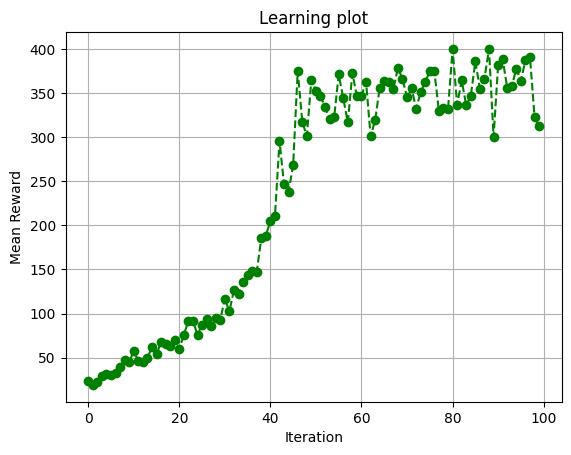

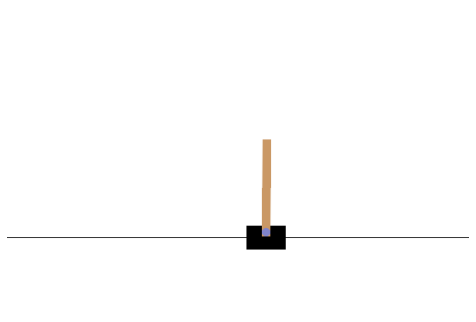

In [ ]:
env = gym.make('CartPole-v1')
state_dim = 4
action_n = 2

class CEM(nn.Module):

    def __init__(self, state_dim, action_n):
        super().__init__()
        self.state_dim = state_dim
        self.action_n = action_n

        self.network = nn.Sequential(nn.Linear(self.state_dim, 128),
                                     nn.ReLU(),
                                     nn.Linear(128, self.action_n)
                                     )

        self.softmax = nn.Softmax()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-2)
        self.loss = nn.CrossEntropyLoss()


    def forward(self, _input):
        return self.network(_input)

    def get_action(self, state):
        state = torch.FloatTensor(state)
        logits = self.forward(state)
        probs = self.softmax(logits).data.numpy()
        action = np.random.choice(self.action_n, p=probs)

        return action


    def fit(self, elite_trajectories):
        elite_states = []
        elite_actions = []
        for trajectory in elite_trajectories:
          for state, action in zip(trajectory['states'], trajectory['actions']):
            elite_states.append(state)
            elite_actions.append(action)
        elite_states = torch.FloatTensor(elite_states)
        elite_actions = torch.LongTensor(elite_actions)

        pred_actions = self.forward(elite_states)

        loss = self.loss(pred_actions, elite_actions)
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()


def get_trajectory(env, agent, max_len=1000, visualize=False):
    trajectory = {'states':[], 'actions': [], 'rewards': []}

    state = env.reset()

    for _ in range(max_len):
        trajectory['states'].append(state)

        action = agent.get_action(state)
        trajectory['actions'].append(action)

        state, reward, done, _ = env.step(action)
        trajectory['rewards'].append(reward)

        if visualize:
            time.sleep(0.01)
            env.render()

        if done:
            break

    return trajectory


agent = CEM(state_dim, action_n)
q_param = 0.9
trajectory_len = 500
trajectory_n = 20
iteration_n = 100



for iteration in range(iteration_n):

    #policy evaluation

    #the array of trajectories
    trajectories = [get_trajectory(env, agent) for _ in range(trajectory_n)]
    #the array of total reward
    total_rewards = [np.sum(trajectory['rewards']) for trajectory in trajectories]
    #and we need average
    print('iteration:', iteration, 'mean total reward:', np.mean(total_rewards))
    #policy improvement (gamma-q)
    quantile = np.quantile(total_rewards, q_param)
    #remain only elite trajectories
    elite_trajectories = []
    for trajectory in trajectories:
        total_reward = np.sum(trajectory['rewards'])
        if total_reward > quantile:
            elite_trajectories.append(trajectory)

    if len(elite_trajectories) > 0:
      agent.fit(elite_trajectories)




trajectory = get_trajectory(env, agent, max_len=500, visualize=True)
print('total reward:', sum(trajectory['rewards']))
